## Sentiment Analysis Project 
We are going to use a Naive Bayes Classifer, because efficient and fast. If time, we will compare it with other methods, especially lexicon & rule-based methods.
The first step of the project is to quickly analyze our data. 

### 1. Exploring the dataset
In this section we will quickly explore the dataset. Namely, we will compute : 
- ratings distribution 
- len of reviews distribution
- word counts distribution
- len of reviews / rating; word_count / rating
- helpfullness / rating / len / word count

In [2]:
## Requirements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

In [3]:
file = pd.read_csv('./data/reviews.csv')

In [4]:
for col in file.columns:
    print(col)

Id
ProductId
UserId
ProfileName
HelpfulnessNumerator
HelpfulnessDenominator
Score
Time
Summary
Text


###### Dataframe feature description (as they appear in the df) : 
- Id : row ID (primary key)
- ProductId : Unique identifier for the product
- UserId : Unqiue identifier for the user
- ProfileName : Profile name of the user
- HelpfulnessNumerator : Number of users who found the review helpful
- HelpfulnessDenominator : Number of users who indicated whether they found the review helpful or not
- Score : Rating between 1 and 5
- Time : Timestamp for the review
- Summary : Brief summary of the review
- Text : Text of the review

In [56]:
# plot the distribution of ratings 
def ratings_distrib(data) :
    array = data['Score'].values
    bins = np.arange(1, array.max() + 1.5) - 0.5
    fig, ax = plt.subplots()
    _ = ax.hist(array, bins, rwidth=0.5, density=True)
    ax.set_xticks([1, 2, 3, 4, 5])
    _=plt.xlabel('Rating')
    _=plt.ylabel('Distribution')
    return plt.show()

# plot the distribution of review length
def len_distrib(data):
    len_str = [len(x) for x in data['Text']]
    _=plt.hist(len_str, density=False, bins = range(0, 4000))
    _=plt.xlabel('Text length in chars')
    _=plt.ylabel('Count')
    return plt.show()

# plot the distribution of word counts, using the nltk RegexpTokenizer
def word_distrib(data):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counts = [len(tokenizer.tokenize(x)) for x in data['Text']]
    _=plt.hist(word_counts, density=False, bins = range(0, 600))
    _=plt.xlabel('Word Counts')
    _=plt.ylabel('Count')
    return plt.show()


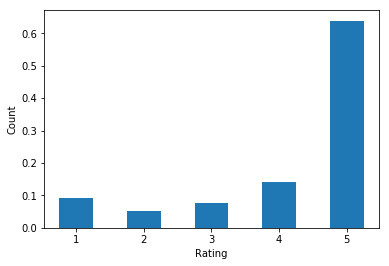

In [53]:
ratings_distrib(file)

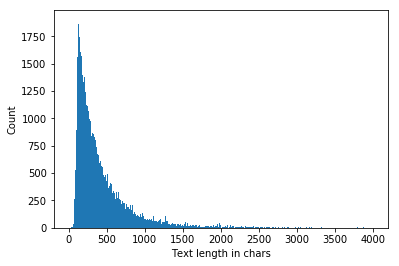

In [54]:
len_distrib(file)

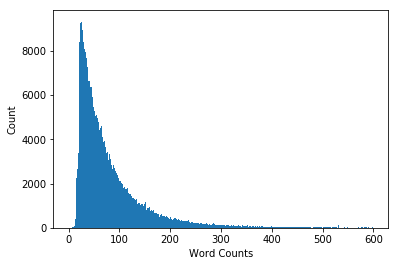

In [55]:
word_distrib(file)

In [88]:
# len distribution per rating 
def len_rating(file) : 
    df = pd.DataFrame(file['Text'], file['Score'])
    df['len'] = [len(x) for x in file['Text']]
    fig, ax = plt.subplots()
    df.boxplot(column = ['len'], by = 'Score', ax=ax, showfliers=False) #outliers removed for clarity
    return plt.show()

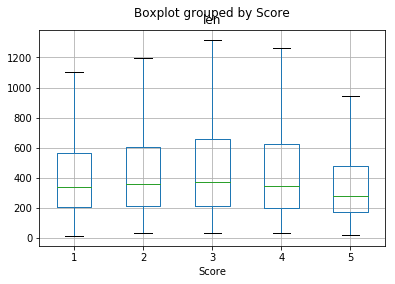

In [89]:
len_rating(file)

In [6]:
# wordcount per rating
def wordcount_rating(file) : 
    df = pd.DataFrame(file['Text'], file['Score'])
    tokenizer = RegexpTokenizer(r'\w+')
    df['word_counts'] = [len(tokenizer.tokenize(x)) for x in file['Text']]    
    fig, ax = plt.subplots()
    df.boxplot(column = ['word_counts'], by = 'Score', ax=ax, showfliers=False) #outliers removed for clarity
    return plt.show()

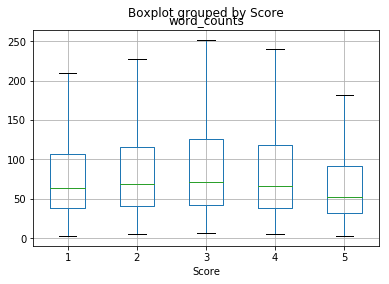

In [7]:
wordcount_rating(file)

In [2]:
# helpfulness coeff (helped readers/readers) per rating  -- Abandon : not useful actually...
def helpfulness_rating(file):
    df = pd.DataFrame(file['Text'], file['HelpfulnessNumerator'], file['HelpfulnessDenominator'], file['Id'])
    dff
    for i in range(0, batch) : 
        dff = 
        df['help_coeff'] = [x/y for x,y in zip(file['HelpfulnessNumerator']['Id'], file['HelpfulnessDenominator'])]
    fig, ax = plt.subplots()
    df.boxplot(column = ['help_coeff'], by = 'Score', ax=ax, showfliers=False) #outliers removed for clarity
    return plt.show()